## Load Packages

In [1]:
#using Dates            #Julia 0.7
using Compat, Missings  #to use 0.7 syntax in 0.6

include("printmat.jl")

printlnPs (generic function with 2 methods)

In [2]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(600,400))
end

Plots.GRBackend()

# The MV Frontier


MV analysis starts with providing the vector of expected returns $\mu$ and the covariance matrix $\Sigma$ of the investable assets.

Then, it plots the "mean variance" frontier: it is a scatter plot showing the lowest possible portfolio standard deviation, Std$(R_p)$, on the horizontal axis at a required average return, $\text{E}R_p=\mu^*$, on the vertical axis. Clearly, we consider many different $\mu^*$ values to create the scatter.

Remember: to calculate the expected return and the variance of a portfolio with portfolio weights in the vector $w$, use 

$\text{E}R_p = w'\mu$ and 

$\text{Var}(R_p) = w'\Sigma w$.

Also, the sum of the portfolio weights should be one.

# MV Frontier  with Two Assets

With only two investable assets, all portfolios of them are on the MV frontier. We can trace out the entire MV frontier by calculating the means and standard deviations of a range of portfolios with different weights ($w_1,1-w_1$) on the two assets.

In [3]:
μ = [0.115; 0.06]            #means
Σ  = [166   58;              #covariance matrix
       58  100]/100^2    

println("expected returns: ")
printmat(μ)
println("covariance matrix:")
printmat(Σ)

expected returns: 
     0.115
     0.060

covariance matrix:
     0.017     0.006
     0.006     0.010



In [4]:
w₁ = 1.5:-0.05:-0.5           #different possible weights on asset 1
n  = length(w₁)

ERp   = fill(NaN,n)
StdRp = fill(NaN,n)
for i = 1:n
    local w                #w is local to the loop
    w        = [w₁[i];1-w₁[i]]
    ERp[i]   = w'μ
    StdRp[i] = sqrt(w'Σ*w)
end   

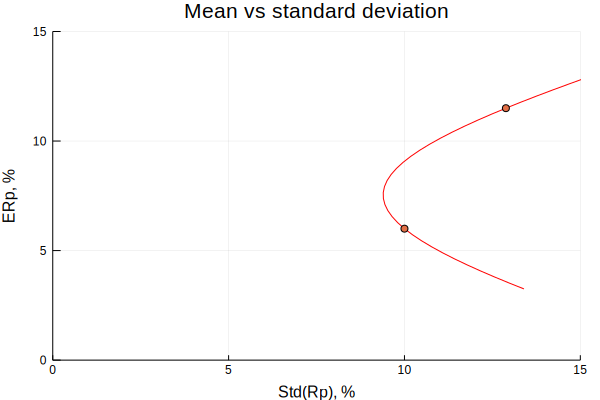

In [5]:
plot2 = plot(StdRp*100,ERp*100,legend=nothing,color=:red,xlim=(0,15),ylim=(0,15))
scatter!(sqrt.(diag(Σ))*100,μ*100)
title!("Mean vs standard deviation")
xlabel!("Std(Rp), %")
ylabel!("ERp, %")

# Calculating the MV Frontier: 3 or More (Risky) Assets

With 3 or more asssets we have to solve the optimization problem

$\min \text{Var}(R_p) \: \text{ s.t. } \: \text{E}R_p = \mu^*$,

and clearly also that the sum of portfolio weights is one. We do not (at this point) impose any further restrictions.

This can be done with a numerical minimization routine or by linear algebra (at least when we do not put any further restrictions on the portfolio weights). The next cells use the linear algrebra approach. 

In [6]:
μ = [0.115; 0.095; 0.06]    #expected returns
Σ  = [166  34  58;              #covariance matrix
       34  64   4;
       58   4 100]/100^2                  
Rf = 0.03

println("μ, Σ and Rf: ")
printmat(μ)
printmat(Σ)
printmat(Rf)

μ, Σ and Rf: 
     0.115
     0.095
     0.060

     0.017     0.003     0.006
     0.003     0.006     0.000
     0.006     0.000     0.010

     0.030



All portfolios on the MV frontier of risky assets only have (a vector of) portfolio weights as in

$w = \Sigma^{-1}(\mu \lambda + \mathbf{1} \delta)$, 

where the scalars $\lambda$ and $\delta$ depend on $(\mu,\Sigma)$ and the required average return $\mu^*$ and where $\mathbf{1}$ is a vector of ones. 

Some of the intermediate calculations are as follows. (Later on we put it all in a function)

In [7]:
mustar = 0.1            #required average return  

n    = length(μ)
oneV = ones(n)          #vector of ones, the bold 1            
 
Σ_1  = inv(Σ)

println("inv(Σ):")
printmat(Σ_1)
println("Σ*inv(Σ):")
printmat(Σ*Σ_1)

A    = μ'Σ_1*μ                  
B    = μ'Σ_1*oneV
C    = oneV'Σ_1*oneV
printlnPs("A, B, C: ",[A B C ])

λ    = (C*mustar - B)/(A*C-B^2)
δ    = (A-B*mustar)/(A*C-B^2)
printlnPs("λ and δ: ",[λ δ])

w    = Σ_1 *(μ*λ + oneV*δ)  #in Julia, we could do Σ_1 *(μ*λ .+ δ)
println("w: ")
printmat(w)

inv(Σ):
    85.735   -42.545   -48.024
   -42.545   177.754    17.566
   -48.024    17.566   127.151

Σ*inv(Σ):
     1.000     0.000     0.000
     0.000     1.000     0.000
    -0.000     0.000     1.000

A, B, C:      1.804    19.759   244.634
λ and δ:      0.093    -0.003
w: 
     0.288
     0.690
     0.022



In [8]:
function MVCalc(mustar,μ,Σ) #the std of a portfolio on MVF of risky assets
    n    = length(μ)
    oneV = ones(n) 
    Σ_1  = inv(Σ)
    A    = μ'Σ_1*μ                 
    B    = μ'Σ_1*oneV
    C    = oneV'Σ_1*oneV
    λ    = (C*mustar - B)/(A*C-B^2)
    δ    = (A-B*mustar)/(A*C-B^2)
    w    = Σ_1 *(μ*λ.+δ)
    StdRp = sqrt(w'Σ*w)
    return StdRp,w
end

MVCalc (generic function with 1 method)

In [9]:
(StdAt10,wAt10) = MVCalc(0.1,μ,Σ)
printlnPs("Just testing: std and w of portfolio with mean return 10: ",StdAt10)
printmat(wAt10)

Just testing: std and w of portfolio with mean return 10:      0.077
     0.288
     0.690
     0.022



In [10]:
mustar = Compat.range(Rf,stop=0.15,length=101)
L      = length(mustar)
StdRp  = fill(NaN,L)                      #loop over different required average returns, (mustar)
for i = 1:L
    StdRp[i] = MVCalc(mustar[i],μ,Σ)[1]   #[1] picks out only the first function output
end

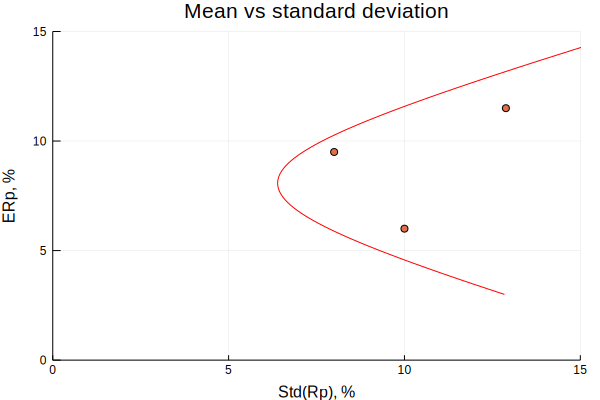

In [11]:
plot3 = plot(StdRp*100,mustar*100,legend=nothing,color=:red,xlim=(0,15),ylim=(0,15))
scatter!(sqrt.(diag(Σ))*100,μ*100)
title!("Mean vs standard deviation")
xlabel!("Std(Rp), %")
ylabel!("ERp, %")

# Calculating the MV Frontier (of Risky and Riskfree Assets)

All portfolios on the MV frontier of both risky and riskfree have (a vector of) portfolio weights on the risky assets as in 

$w=\frac{\mu^{\ast}-R_{f}}{(\mu^{e})^{\prime}\Sigma^{-1}\mu^{e}}\Sigma^{-1}
\mu^{e}$, 

where $\mu^*$ is the required average return.

The weight of the riskfree asset is $1-\mathbf{1}'w$

In [12]:
function MVCalcRf(mustar,μ,Σ,Rf)           #calculates the std of a portfolio on MVF of (Risky,Riskfree)
    n     = length(μ)
    μe    = μ .- Rf                        #expected excess returns            
    Σ_1   = inv(Σ)
    w     = (mustar-Rf)/(μe'Σ_1*μe) * Σ_1*μe
    StdRp = sqrt(w'Σ*w)
    return StdRp,w
end

MVCalcRf (generic function with 1 method)

In [13]:
StdRpRf  = fill(NaN,L)                 #loop over required average returns (mustar)
for i = 1:L
    StdRpRf[i] = MVCalcRf(mustar[i],μ,Σ,Rf)[1]
end    

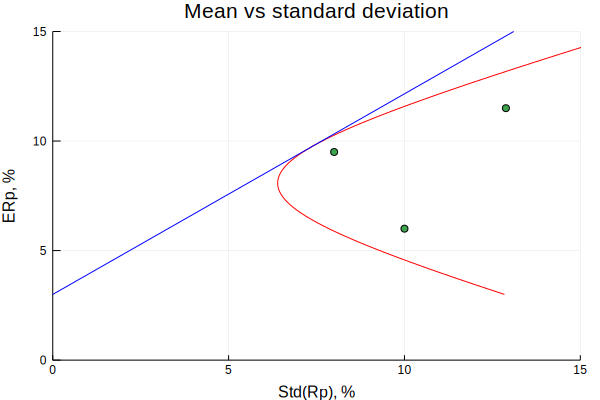

In [14]:
plot4 = plot(StdRp*100,mustar*100,legend=nothing,color=:red,xlim=(0,15),ylim=(0,15))
plot!(StdRpRf*100,mustar*100,legend=nothing,color=:blue)
scatter!(sqrt.(diag(Σ))*100,μ*100)
title!("Mean vs standard deviation")
xlabel!("Std(Rp), %")
ylabel!("ERp, %")

# Tangency Portfolio

The tangency portfolio is a particular portfolio on the MV frontier of risky and riskfree, where the weights on the risky assets sum to one. It is therefore also on the MV frontier of risky assets only. The vector of portfolio weights is

$w_{T}=\frac{\Sigma^{-1}\mu^{e}}{\mathbf{1}^{\prime}\Sigma^{-1}\mu^{e}}$

In [15]:
function MVTangencyP(μ,Σ,Rf)           #calculates the tangency portfolio
    n     = length(μ)
    oneV  = ones(n)  
    μe    = μ .- Rf                    #expected excess returns            
    Σ_1   = inv(Σ)
    w     = Σ_1 *μe/(oneV'Σ_1*μe)
    muT   = w'μ + (1-sum(w))*Rf
    StdT = sqrt(w'Σ*w)
    return w,muT,StdT
end

MVTangencyP (generic function with 1 method)

In [16]:
(wT,muT,StdT) = MVTangencyP(μ,Σ,Rf)
println("Tangency portfolio: ")
printmat(wT)
printlnPs("mean and std of tangency portfolio, %: ",[muT StdT]*100)

Tangency portfolio: 
     0.248
     0.682
     0.070

mean and std of tangency portfolio, %:      9.750     7.372


By mixing the tangency portfolio and the riskfree, we can create any point on the MV frontier of risky and riskfree (also called the Capital Market Line, CML). 

The code below shows the expected return and standard deviation of several portfolio (different $v$ values) of the form

$R_p = v R_T + (1-v)R_f$ where $R_T=w_T'R$

In [17]:
v = [0;0.44;1;1.41]                                 #try different mixes of wT and Rf

(ERLev,StdLev)  = (similar(v),similar(v))           #to store results in
for i = 1:length(v)                    #loop over different v values (mix of wT and Rf)
    ERLev[i]   = v[i]'muT + (1-v[i])*Rf     #portfolio with v[i] in wT and 1-v[i] in Rf
    StdLev[i]  = abs(v[i])*StdT
end

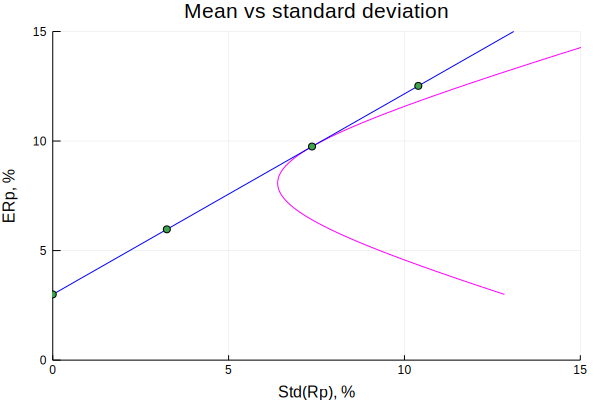

In [18]:
plot(StdRp*100,mustar*100,legend=nothing,color=:magenta,xlim=(0,15),ylim=(0,15))
plot!(StdRpRf*100,mustar*100,legend=nothing,color=:blue)
scatter!(StdLev*100,ERLev*100)
title!("Mean vs standard deviation")
xlabel!("Std(Rp), %")
ylabel!("ERp, %")

## Examples of Tangency Portfolios

In [19]:
μb = [9; 6]/100                     #means
Σb = [ 256  0;
      0    144]/100^2
Rfb = 1/100
wT, = MVTangencyP(μb,Σb,Rfb)
printmat(wT)

wT, = MVTangencyP([13; 6]/100,Σb,Rfb)
printmat(wT)

Σb = [ 1  -0.8;
      -0.8    1]
wT, = MVTangencyP(μb,Σb,Rfb)
printmat(wT)

Σb = [ 1  0.8;
      0.8    1]
wT, = MVTangencyP(μb,Σb,Rfb)
printmat(wT)

     0.474
     0.526

     0.574
     0.426

     0.513
     0.487

     1.538
    -0.538



# Drawing the MV Frontier Revisisted (extra)

Recall: with only two investable assets, all portfolios of them are on the MV frontier.

We apply this idea by using the global minimum variance portfolio (see below for code) and the tangency portfolios (see above).

In [20]:
function MVMinimumVarP(μ,Σ,Rf)           #calculates the global minimum variance portfolio
    n     = length(μ)
    oneV  = ones(n)  
    μe    = μ .- Rf                     
    Σ_1   = inv(Σ)
    w     = Σ_1*oneV/(oneV'Σ_1*oneV)
    mu    = w'μ + (1-sum(w))*Rf
    Std   = sqrt(w'Σ*w)
    return w,mu,Std
end

MVMinimumVarP (generic function with 1 method)

In [21]:
(wT,muT,StdT) = MVTangencyP(μ,Σ,Rf)
(wMvp,muMvp,StdMvp) = MVMinimumVarP(μ,Σ,Rf)
println("Tangency and minum variance portfolios: ")
printmat([wT wMvp])

Tangency and minum variance portfolios: 
     0.248    -0.020
     0.682     0.625
     0.070     0.395



In [22]:
v = Compat.range(-2.5,stop=2.5,length=101)                      #try different mixes of wT and wMvp

(ERLev,StdLev)  = (similar(v),similar(v))
for i = 1:length(v)
    local w
    w          = v[i]*wT + (1-v[i])*wMvp                        #portfolio with v[i] in wT and 1-v[i] in wMvp
    ERLev[i]   = w'μ
    StdLev[i]  = sqrt(w'Σ*w)
end

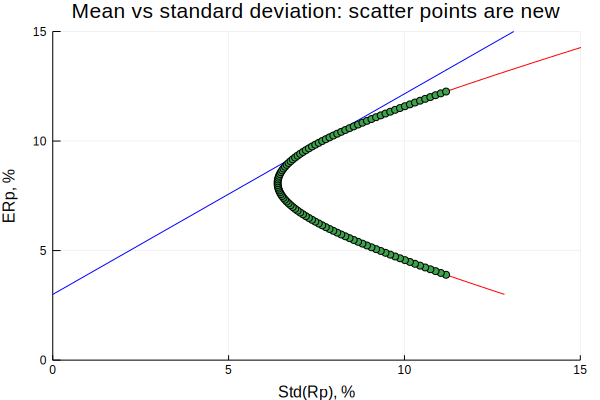

In [23]:
plot(StdRp*100,mustar*100,legend=nothing,color=:red,xlim=(0,15),ylim=(0,15))
plot!(StdRpRf*100,mustar*100,legend=nothing,color=:blue)
scatter!(StdLev*100,ERLev*100)
title!("Mean vs standard deviation: scatter points are new")
xlabel!("Std(Rp), %")
ylabel!("ERp, %")